<a href="https://colab.research.google.com/github/nazaninaslani/TimeSeries-Demand-Prediction/blob/main/FinalSarimaDemandForecaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Demand Forecast in Family Health Team

# Background

## Project goal

In [ ]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import itertools
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
import seaborn as sns
from datetime import datetime, timedelta

In [53]:
# Load specific statistical tool for outlier detection
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.stattools import medcouple
import math

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
import pmdarima
from pmdarima import auto_arima                              # for determining ARIMA orders
#normalizing input & output features
from sklearn.preprocessing import MinMaxScaler
#tools for evaluating the forecasting model
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
##
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

#Datasets

In [5]:
Demand = pd.read_csv('DailyDemand.csv')
print(Demand.head())
len(Demand)

   Unnamed: 0  Provider Id  ... Appointment Type  Doctor Id
0           0          128  ...       non-urgent         38
1           1           94  ...       non-urgent         37
2           3          114  ...       non-urgent         16
3           4           25  ...           urgent         21
4           5          144  ...           urgent         26

[5 rows x 6 columns]


40754

# Pipline for handling missing values & cleaning dataset

In [6]:
def clean_data (df_in,col_1,col_2,val_2,col_3,val_3,col_4,val_4):
  #Removing the missing values
  df_in.dropna(subset=[col_1], inplace = True)
  #Removing records with negative access time
  df_in = df_in[df_in[col_1]>=0]
  #
  df_in = df_in[df_in[col_3] == val_3]
  #Specific app type
  df_in = df_in[df_in[col_2] == val_2]
  #Handling the categorial variable
  df_in[col_2] = np.where(df_in[col_2]== val_2,1,0)
  df_in['CareContinuity'] = np.where((df_in[col_4]==val_4),1,0 )
  return df_in

In [7]:
Demand = clean_data(Demand,'Wait Interval','Appointment Type','urgent','Doctor Id',32,'Provider Id',96)

In [8]:
Demand

,Unnamed: 0,Provider Id,Booking Date,Wait Interval,Appointment Type,Doctor Id,CareContinuity
92,130,96,30-Aug-17,1.0,1,32,1
104,149,96,31-Aug-17,0.0,1,32,1
112,158,96,29-Aug-17,2.0,1,32,1
123,172,96,29-Aug-17,2.0,1,32,1
225,371,95,24-Aug-17,11.0,1,32,0
...,...,...,...,...,...,...,...
40676,60566,96,24-Aug-18,6.0,1,32,1
40679,60570,95,31-Aug-18,0.0,1,32,0
40681,60574,96,29-Aug-18,1.0,1,32,1
40688,60583,95,31-Aug-18,0.0,1,32,0


#Pipline for handling the outliers

In [9]:
def Outlier_handle(df_in, col_name):
  
  #Calculating Medcouple for adjusted boxplot
  
  MC = medcouple(df_in[col_name])
  
  #Calculating IQR
  Q1 = df_in[col_name].quantile(0.25)
  Q3 = df_in[col_name].quantile(0.75)
  IQR = Q3 - Q1
  
  #print(IQR)
  
  #Removing outliers through defining adjusted boxplot based on medcouple function for skewed distribution
  
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  IQR = q3-q1 #Interquartile range
  fence_low  = q1-1.5*math.exp(-3.5*MC)*IQR
  fence_high = q3+1.5*math.exp(-3.5*MC)*IQR
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  
  return df_out

In [10]:
Demand = Outlier_handle(Demand,'Wait Interval')

In [ ]:
Demand

,Unnamed: 0,Provider Id,Booking Date,Wait Interval,Appointment Type,Doctor Id,CareContinuity
92,130,96,30-Aug-17,1.0,1,32,1
104,149,96,31-Aug-17,0.0,1,32,1
112,158,96,29-Aug-17,2.0,1,32,1
123,172,96,29-Aug-17,2.0,1,32,1
225,371,95,24-Aug-17,11.0,1,32,0
...,...,...,...,...,...,...,...
40676,60566,96,24-Aug-18,6.0,1,32,1
40679,60570,95,31-Aug-18,0.0,1,32,0
40681,60574,96,29-Aug-18,1.0,1,32,1
40688,60583,95,31-Aug-18,0.0,1,32,0


# Pipline for preprocessing the timeSeries data & creating new features 


In [11]:
def preprocess_df (df_in,col_date,col_feature1,col_feature2):
  
  #df_in = df_in[['Booking Date', 'Appointment Type','Doctor Id']]
  df_in = df_in.loc[:,[col_date,col_feature1,col_feature2]]
  #Converting object into datetime for booking date
  df_in[col_date] = pd.to_datetime(df_in[col_date])
  #Sorting based on booking date
  df_in = df_in.sort_values(by=col_date,ascending=True)
  #Calculating total demand per day for a specific doctor
  df_in = df_in.groupby(by=[col_date], as_index=False).aggregate(pd.np.sum)
  #Changing the name of the feature column
  df_in.rename(columns= {col_feature1:'Urgent Daily Demand'}, inplace= True)
  df_in.set_index(col_date, inplace=True)
  df_in = df_in.asfreq('D')
  df_in.reset_index(inplace=True)
  #adding a feature for continuity of care
  #df_in['CareContinuity'] = np.where((df_in[col_feature1]==96),1,0 )
  #adding a feature for days of a week
  df_in['Weekday'] = df_in[col_date].dt.day_name()
  #Since the original booking dates in the dataset is due to the existence of demand, after creating a daily based time series, daily demand for the booking dates which are not in the original dataset is Null value. So the Null values are replaced with zero replacing the null values with zero
  df_in['Urgent Daily Demand'] = df_in['Urgent Daily Demand'].fillna(0)
  df_in['CareContinuity'] = df_in['CareContinuity'].fillna(0)
  #adding feature for each day of a week
  df_in['Monday'] =  np.where(df_in['Weekday']=='Monday',1,0)
  df_in['Tuesday'] = np.where(df_in['Weekday']=='Tuesday',1,0)
  df_in['Wednesday'] = np.where(df_in['Weekday']=='Wednesday',1,0)
  df_in['Thursday'] = np.where(df_in['Weekday']=='Thursday',1,0)
  df_in['Friday'] = np.where(df_in['Weekday']=='Friday',1,0)
  df_in.set_index('Booking Date', inplace=True)

  return df_in

In [12]:
Demand = preprocess_df(Demand,'Booking Date','Appointment Type','CareContinuity')

In [13]:
Demand

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


#Plot the source data

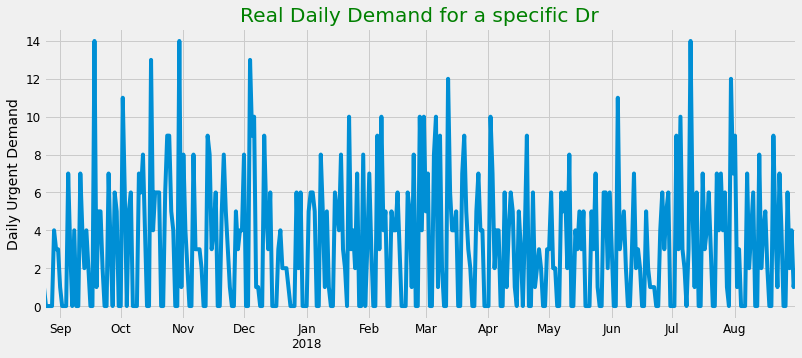

In [14]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Daily Demand for a specific Dr'
ylabel='Daily Urgent Demand'
xlabel='' # we don't really need a label here

ax = Demand['Urgent Daily Demand'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Run an ETS Decomposition

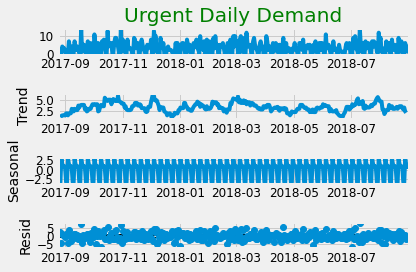

In [15]:
result = seasonal_decompose(Demand['Urgent Daily Demand'])
result.plot();

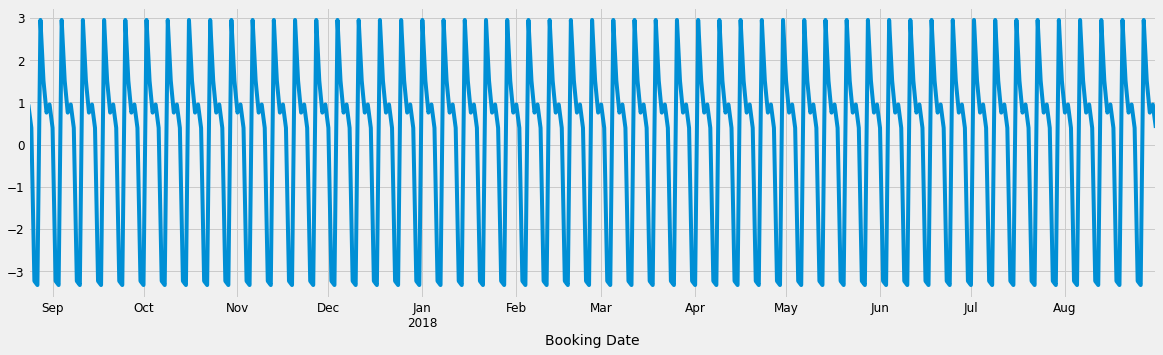

In [16]:
#result.trend.plot(figsize=(18,5))
result.seasonal.plot(figsize=(18,5))
#result.resid.plot(figsize=(18,5));

Due to the presence of seasonality, SARIMA is used as a forecasting model

#Pipline to check if the time series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(Demand['Urgent Daily Demand'],title='')

#Building a SARIMA model

**SARIMA configuration**
A seasonal ARIMA model is classified as an "ARIMA(p,d,q)x(P,D,Q)" model, where:
(p,d,q) describes the non-seasonal part and (P,D,Q) describes the seasonal part.


*   **p** is the number of autoregressive term
*   **d** is the number of nonseasonal difference needed for stationarity
*   **q** is the number of lagged forecast errors in the prediction equation
*   **P** is the number of seasonal autoregressive term (SAR).
*   **D** is the number of seasonal differences.
*   **Q** is the number of seasonal moving average (SMA) terms.

**Step 1:** spliting the dataset into train/test sets


In [17]:
def train_test_split(df_in, train_prop):
  train_size=int(len(df_in) *train_prop)
  test_size = int(len(df_in)) - train_size
  
  return df_in[:-test_size], df_in[-test_size:]

In [18]:
trainset, testset = train_test_split(Demand, 0.7)

In [19]:
trainset

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-05-07,6.0,4.0,Monday,1,0,0,0,0
2018-05-08,5.0,4.0,Tuesday,0,1,0,0,0
2018-05-09,6.0,3.0,Wednesday,0,0,1,0,0


In [20]:
testset

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2018-05-12,0.0,0.0,Saturday,0,0,0,0,0
2018-05-13,0.0,0.0,Sunday,0,0,0,0,0
2018-05-14,4.0,3.0,Monday,1,0,0,0,0
2018-05-15,3.0,1.0,Tuesday,0,1,0,0,0
2018-05-16,5.0,2.0,Wednesday,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


**Step 2:** using autocorrelation plots finding initial parameters for SARIMA model. an initial AR order p can be determined by sample PACF (partial auto correlation). If the PACF cuts off after some lags, that number is the order of AR. Also, an initial MA order q can be determined by looking at the sample ACF (auto correlation). If the ACF cuts off after some lags, that number is the order of MA.


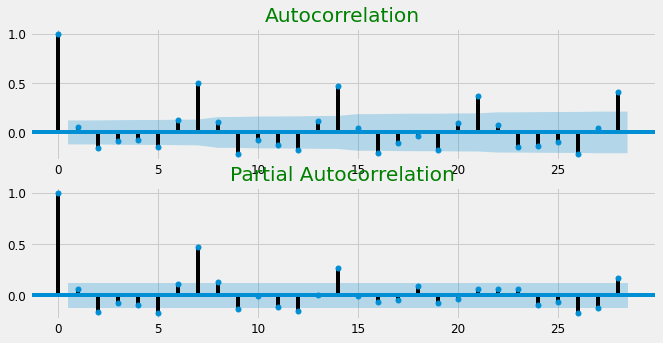

In [21]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(trainset['Urgent Daily Demand'], lags=28, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(trainset['Urgent Daily Demand'], lags=28, ax=ax[1])
plt.show()

Since both ACF and PACF presents significant lags in weekly seasonal pattern, I took the difference of demand values

In [22]:
# create a differenced series
def difference(df_in, interval=1):
	diff = list()
	for i in range(interval, len(df_in)):
		value = df_in[i] - df_in[i - interval]
		diff.append(value)
	return np.array(diff)

In [23]:
# invert differenced value
def inverse_difference(history, yhat, interval):
	return yhat + history[-interval]

In [24]:
ydiff = trainset['Urgent Daily Demand'].values
daysinweek = 7
differenced = difference(ydiff, daysinweek)

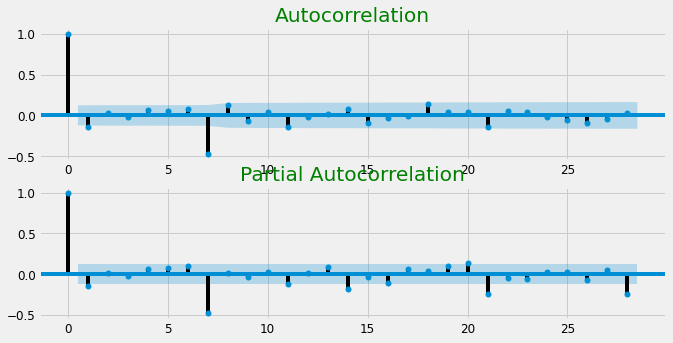

In [25]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(differenced, lags=28, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(differenced, lags=28, ax=ax[1])
plt.show()



1.   ACF plot shows significant lags to 1 time step and 7 time steps
2.   PACF plot shows signiant lags at 1 time step and 7,14,21 time steps
3.   Therefore as start point we start with SARIMA (1,0,0)(2,1,1)[7]



**Step3:** training the model

In [28]:
model= SARIMAX(trainset['Urgent Daily Demand'],order=(1,0,1),seasonal_order=(2,1,1,7),
 enforce_invertibility=False, enforce_stationarity=False)
#Fiting the model
results= model.fit()
train_size=int(len(Demand) *0.7)
test_size = int(len(Demand)) - train_size
#Forecasting
forecast_sarima= results.forecast(steps=test_size)
forecast_sarima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2018-05-12    0.309208
2018-05-13   -0.217313
2018-05-14    7.194307
2018-05-15    4.465190
2018-05-16    4.628198
                ...   
2018-08-27    7.014747
2018-08-28    4.644401
2018-08-29    4.353239
2018-08-30    4.259882
2018-08-31    3.888750
Freq: D, Name: predicted_mean, Length: 112, dtype: float64

**Step 4:**Time Series Cross Validation (Walk forward approach)

predicted=-0.084270, expected=0.000000
predicted=0.168827, expected=0.000000
predicted=6.423213, expected=4.000000
predicted=4.920028, expected=3.000000
predicted=4.369773, expected=5.000000
predicted=3.962740, expected=3.000000
predicted=4.137231, expected=5.000000
predicted=0.165640, expected=0.000000
predicted=-0.068336, expected=0.000000
predicted=6.330256, expected=0.000000
predicted=4.530761, expected=5.000000
predicted=4.310774, expected=3.000000
predicted=4.070814, expected=7.000000
predicted=3.726332, expected=1.000000
predicted=0.473778, expected=0.000000
predicted=-0.342697, expected=0.000000
predicted=5.866875, expected=6.000000
predicted=4.379534, expected=6.000000
predicted=4.330460, expected=2.000000
predicted=4.415534, expected=6.000000
predicted=3.408075, expected=3.000000
predicted=0.034724, expected=0.000000
predicted=0.049578, expected=0.000000
predicted=6.323838, expected=11.000000
predicted=4.733248, expected=3.000000
predicted=4.127536, expected=4.000000
predicte

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=5.488307, expected=1.000000
predicted=3.742367, expected=6.000000
predicted=0.080848, expected=0.000000
predicted=0.155526, expected=0.000000
predicted=5.495707, expected=7.000000
predicted=6.170976, expected=3.000000
predicted=4.462642, expected=4.000000
predicted=3.794961, expected=6.000000
predicted=3.764299, expected=3.000000
predicted=0.275102, expected=0.000000
predicted=-0.029617, expected=0.000000
predicted=6.212369, expected=7.000000
predicted=4.783610, expected=4.000000
predicted=4.162640, expected=7.000000
predicted=4.104634, expected=4.000000
predicted=3.731515, expected=6.000000
predicted=-0.149276, expected=1.000000
predicted=0.014014, expected=0.000000
predicted=6.290549, expected=12.000000
predicted=4.253824, expected=7.000000
predicted=4.436754, expected=9.000000
predicted=3.885390, expected=1.000000
predicted=4.377507, expected=3.000000
predicted=0.150200, expected=0.000000
predicted=0.058479, expected=0.000000
predicted=6.976101, expected=0.000000
predicted

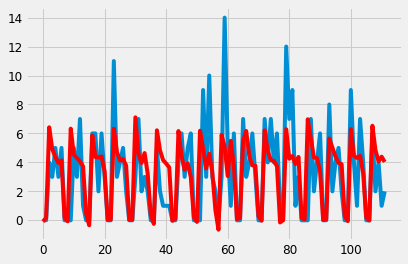

In [30]:
history = [x for x in trainset['Urgent Daily Demand']]
test = testset['Urgent Daily Demand'].values
predictions = list()
for t in range(len(test)):
  model = SARIMAX(history, order=(1,0,1),seasonal_order=(2,1,1,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
error3 = rmse((test), (predictions))
print('SARIMA(1,0,1)(2,1,1)[7] MAE Error: %.3f' %error1)
print('SARIMA(1,0,1)(2,1,1)[7] MSE Error: %.3f' %error2)
print('SARIMA(1,0,1)(2,1,1)[7] RMSE Error: %.3f'%error3)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [31]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err

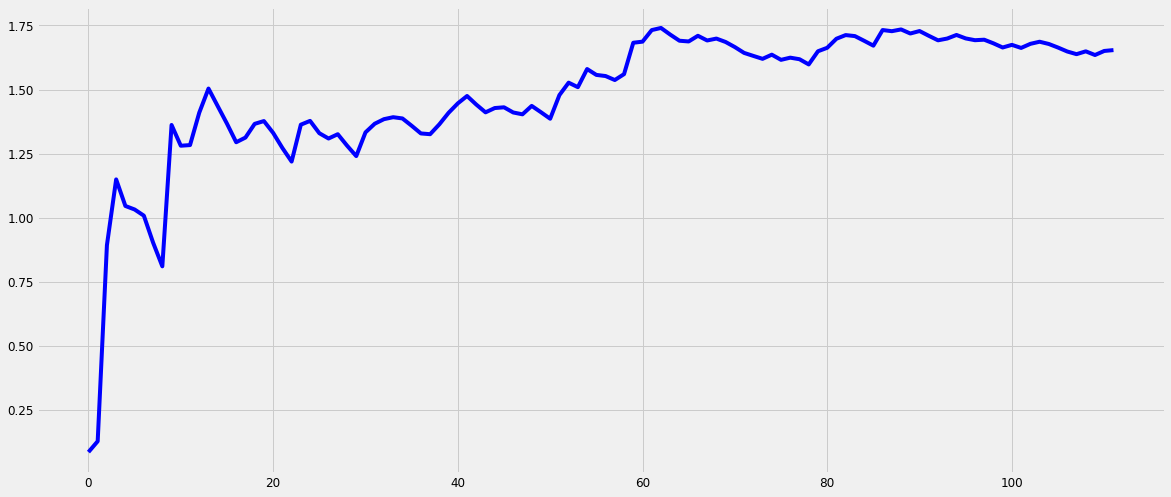

In [33]:
Sarimaerr = retrive_cum_rmse(test,predictions)
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(Sarimaerr, 'b', label='Sarima')

**Step5:** Improving the model (Grid search)

Creating a set of sarima configs to try

In [58]:
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	#t_params = ['n','c','t','ct']
	#P_params = [1, 2]
	#D_params = [1]
	#Q_params = [1, 2]
	#m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				#for t in t_params:
					#for P in P_params:
						#for D in D_params:
							#for Q in Q_params:
								#for m in m_params:
									cfg = [(p,0,q), (1,1,1,7), 'n']
									models.append(cfg)
	return models


In [59]:
# model configs
cfg_list = sarima_configs()
cfg_list

[[(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 2), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 2), (1, 1, 1, 7), 'n'],
 [(1, 0, 0), (1, 1, 1, 7), 'n'],
 [(1, 0, 1), (1, 1, 1, 7), 'n'],
 [(1, 0, 2), (1, 1, 1, 7), 'n'],
 [(1, 0, 0), (1, 1, 1, 7), 'n'],
 [(1, 0, 1), (1, 1, 1, 7), 'n'],
 [(1, 0, 2), (1, 1, 1, 7), 'n'],
 [(2, 0, 0), (1, 1, 1, 7), 'n'],
 [(2, 0, 1), (1, 1, 1, 7), 'n'],
 [(2, 0, 2), (1, 1, 1, 7), 'n'],
 [(2, 0, 0), (1, 1, 1, 7), 'n'],
 [(2, 0, 1), (1, 1, 1, 7), 'n'],
 [(2, 0, 2), (1, 1, 1, 7), 'n']]

In [37]:
#One step SARIMA forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [38]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [39]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [40]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [41]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [42]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [46]:
Demand

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


In [47]:
df_demand = Demand[['Urgent Daily Demand']]

In [49]:
df_demand.to_csv('df_demand.csv', header=False)

In [51]:
#load data
series = pd.read_csv('df_demand.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#prepare data
data = series.values
data = data.astype('float32')
n_test = int(len(data)*0.70)

In [60]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 2), (1, 1, 1, 7), 'n']] 2.373
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 2), (1, 1, 1, 7), 'n']] 2.373
 > Model[[(1, 0, 0), (1, 1, 1, 7), 'n']] 2.374
 > Model[[(1, 0, 1), (1, 1, 1, 7), 'n']] 2.388
 > Model[[(1, 0, 0), (1, 1, 1, 7), 'n']] 2.374
 > Model[[(1, 0, 2), (1, 1, 1, 7), 'n']] 2.389
 > Model[[(1, 0, 1), (1, 1, 1, 7), 'n']] 2.388
 > Model[[(2, 0, 0), (1, 1, 1, 7), 'n']] 2.372
 > Model[[(1, 0, 2), (1, 1, 1, 7), 'n']] 2.389
 > Model[[(2, 0, 1), (1, 1, 1, 7), 'n']] 2.395
 > Model[[(2, 0, 0), (1, 1, 1, 7), 'n']] 2.372
 > Model[[(2, 0, 2), (1, 1, 1, 7), 'n']] 2.393
 > Model[[(2, 0, 1), (1, 1, 1, 7), 'n']] 2.395
 > Model[[(2, 0, 2), (1, 1, 1, 7), 'n']] 2.393


In [61]:
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

[(2, 0, 0), (1, 1, 1, 7), 'n'] 2.3716612419293313
[(2, 0, 0), (1, 1, 1, 7), 'n'] 2.3716612419293313
[(0, 0, 2), (1, 1, 1, 7), 'n'] 2.3730788955072337


Comparision

# Diagnostic test for the selected model